<a href="https://colab.research.google.com/github/AGrantHewitt/Classification-Modeling/blob/main/BioChemistry_Classifications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#First choice: Crystal Structures Classification

filename = "/content/drive/MyDrive/Coding Dojo/Project 2/Crystal_structure.csv"
df = pd.read_csv(filename)
df.tail()

,Compound,A,B,In literature,v(A),v(B),r(AXII)(Å),r(AVI)(Å),r(BVI)(Å),EN(A),EN(B),l(A-O)(Å),l(B-O)(Å),ΔENR,tG,τ,μ,Lowest distortion
5324,ZrWO3,Zr,W,False,1,5,0.89,0.72,0.62,1.33,2.36,2.38342,1.745600,-1.572214,0.801621,5.228952455,0.442857,cubic
5325,ZrYO3,Zr,Y,False,-,-,0.89,0.72,0.90,1.33,1.22,2.38342,2.235124,-2.489571,0.704032,-,0.642857,cubic
5326,ZrYbO3,Zr,Yb,False,-,-,0.89,0.72,0.95,1.33,1.10,2.38342,2.223981,-2.626821,0.689053,-,0.678571,orthorhombic
5327,ZrZnO3,Zr,Zn,False,-,-,0.89,0.72,0.74,1.33,1.65,2.38342,2.096141,-2.035750,0.756670,-,0.528571,cubic
5328,Zr2O3,Zr,Zr,False,-,-,0.89,0.72,0.72,1.33,1.33,2.38342,2.043778,-2.097821,0.763809,-,0.514286,cubic


In [3]:
# 1) Source of data
#https://www.kaggle.com/datasets/sayansh001/crystal-structure-classification?select=Crystal_structure.csv

In [4]:
# 2) Brief description of data
# This dataset shows the numerous studies of perovskite structures. 
# An ideal perovskite has an ABX3 structure where A and B are two differently sized cations, and X is an anion. (This is not confined to one specific structure)
# Features such as electronegativity, ionic radius, valence, and bond lengths of A-O and B-O pairs have been identified that enable a priori crystal structure prediction. 
# Each observation is used to predict the crystal structure to be either a cubic, tetragonal, orthorhombic, or rhombohedral structure.

In [5]:
# 3) What is the target?
#Lowest Distortion 

In [6]:
# 4) Is this a classification or regression problem?
#Classification (Multi-Class)

In [7]:
# 5) How many features?
# 13

In [8]:
# 6) How many rows of data.
df.shape #5329 rows

(5329, 18)

In [9]:
# 7) What, if any, challenges do your foresee in cleaning, exploring, or modeling with this dataset?
#There are some missing values I will have to address. 
#This is a decent sized data set and I don't want to lose data that would make the model less efficient.
#For now the goal is to determine the different crystal structures but the challenge will be to determine which compounds have ideal structures.

In [10]:
#Column Dictionary
#Compound	 - The chemical formula of the compund 
#A	- element A
#B	- element B
#In literature - if the compund is found in literature
# v(A) - Valence of A
# v(B) - Valence of B
# Radius A (r(AXII)) - ionic radius of A cation
# Radius B (r(AVI)) - ionic radius of B cation
# Radius X (r(BVI)) - ionic radius of X anion (O3)
# Electronegativity of A (EN(A)) - Average electronegativity value of A cation
# Electronegativity of B (EN(B)) - Average electronegativity value of B cation
# l(A-O) - Bond length of A-O pair
# l(B-O) - Bond length of B-O pair
# ΔENR - Electronegativity difference with radius
# tG - Goldschmidt tolerance factor
# τ New tolerance factor
# μ - Octahedral factor
# Lowest Distortion - crystal structure

In [11]:
df_0 = df.copy() #original uncleaned dataset
#delete unnecessary columns
#I feel that "Compound" should be dropped. The A and B column state the two different elements and oxygen is in all the compounds so that becomes redundant.
#It is easier to determine the compund given the two elements and the structure.
#I also feel that "In Literature" is an unnessecary column. How will knowing if this compound is in literature help predict the structure? 
#It most likely won't. 
#All other columns are measurements within the compound that aid in determining the structure shape
df.drop(columns=["Compound","In literature"], inplace = True)

In [12]:
#delete duplicate rows
df.duplicated().sum()

0

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5329 entries, 0 to 5328
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   A                  5329 non-null   object 
 1   B                  5329 non-null   object 
 2   v(A)               5329 non-null   object 
 3   v(B)               5329 non-null   object 
 4   r(AXII)(Å)         5329 non-null   float64
 5   r(AVI)(Å)          5329 non-null   float64
 6   r(BVI)(Å)          5329 non-null   float64
 7   EN(A)              5329 non-null   float64
 8   EN(B)              5329 non-null   float64
 9   l(A-O)(Å)          5329 non-null   float64
 10  l(B-O)(Å)          5329 non-null   float64
 11  ΔENR               5329 non-null   float64
 12  tG                 5329 non-null   float64
 13  τ                  5329 non-null   object 
 14  μ                  5329 non-null   float64
 15  Lowest distortion  5329 non-null   object 
dtypes: float64(10), object(6

In [14]:
#identify and addressed missing values 
df.isna().sum() 
#technically there are no missing values (NaN) but there are cells with a place holder (-)
#I am unsure if the dash will mess up the model.

(df == "-").sum()

#I am assuming that the valencies of a & b are missing for the same compund. 
# inputting each valency will take a long time and imputing causes errors in the data. 
# dropping the row will remove a lot of info from the data but 3000 rows is still good.
# I will first try dropping the rows, then the columns, then encoding to find the best result   
df = df[df['v(A)'] != '-']
df = df[df['v(B)'] != '-']

# I am also going to drop the tau colomn because more than half of the data is missing.
df.drop(columns="τ", inplace = True)
df['v(A)'] = df['v(A)'].astype(int)
df['v(B)'] = df['v(B)'].astype(int)
#I will also remove the rows with missing data in lower distortion. These are negligible 
df = df[df['Lowest distortion'] != '-']

In [15]:
#identified and corrected inconsistencies in data for categorical values (i.e. Cat, cat, cats)
#the only categorical column in the target column "lowest distortion"
df["Lowest distortion"].value_counts()

cubic           2170
orthorhombic     968
rhombohedral     210
tetragonal        78
Name: Lowest distortion, dtype: int64

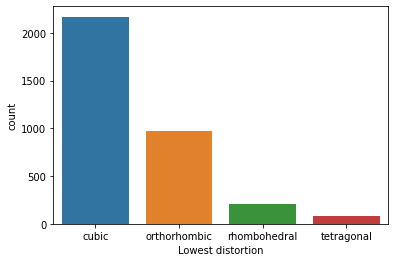

In [16]:
#produced univariate visuals for the target and all features
sns.countplot(data = df, x = df["Lowest distortion"]);
#the most common class is cubic. However this does not automatically mean it is the ideal structure.

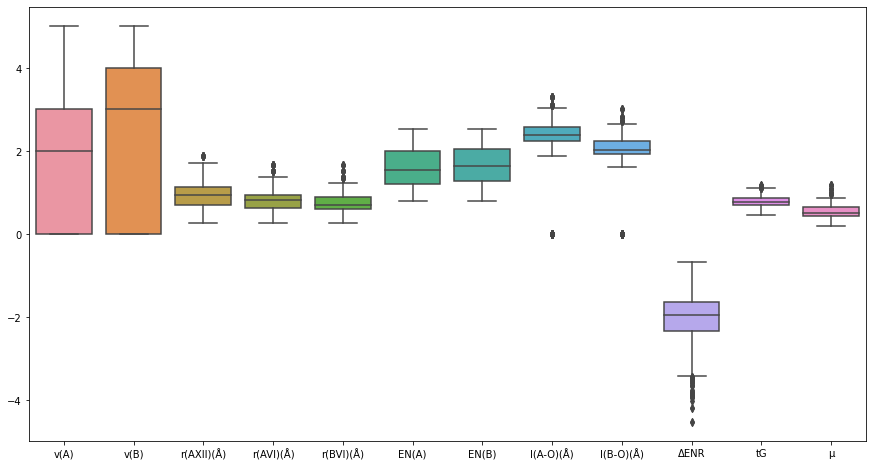

In [17]:
#identified outliers
plt.figure(figsize=(15,8))
sns.boxplot(data = df );

#I will delete the extreme outliers in the bond lengths and ENR columns

In [18]:
df = df[df['l(A-O)(Å)'] != 0]
df = df[df['l(B-O)(Å)'] != 0]
df = df[df['ΔENR'] > -3.8]

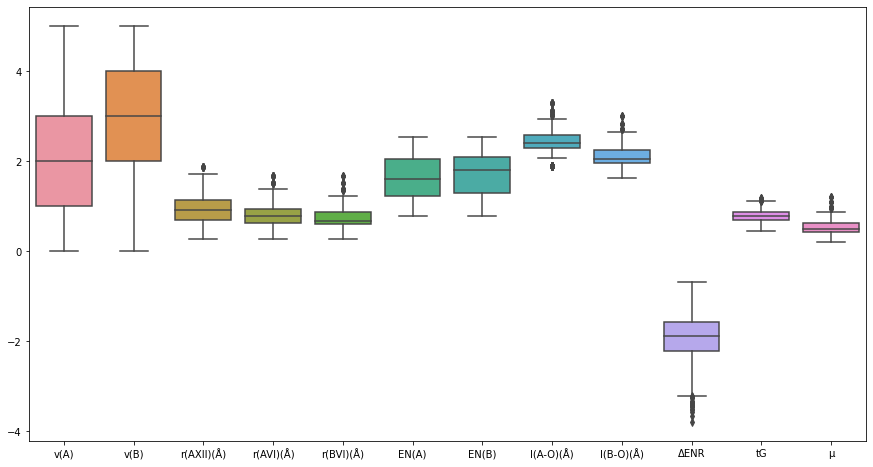

In [19]:
plt.figure(figsize=(15,8))
sns.boxplot(data = df );

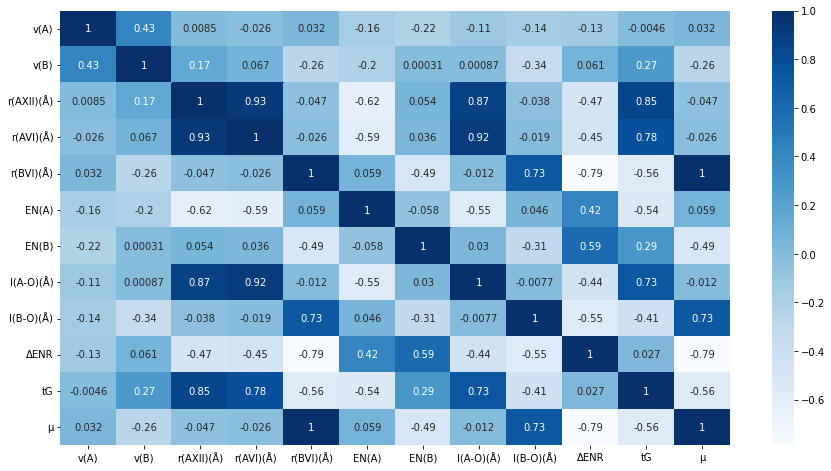

In [20]:
#produce a correlation heatmap and identify any moderate or strong correlations between your target and your features and/or between one feature and another
plt.figure(figsize=(15,8))
corr = df.corr()
sns.heatmap(corr, cmap = 'Blues', annot = True); 

#We see that Ionic radius of A cation [r(AXII)(Å)] and Ionic radius of B cation [r(AVI)(Å)] are postively correlated (0.94)
#We also see that the Ionic radius of X anion [r(BVI)(Å)] and the Octahedral factor [μ] are postively correlated (1)


In [21]:
#Creating multivariate exploratory visuals to further understand your data
sns.pairplot(df, hue = "Lowest distortion");
#this shows the correlation plot but in scatter plot formation

Error in callback <function flush_figures at 0x7f0fd60323b0> (for post_execute):


KeyboardInterrupt: ignored

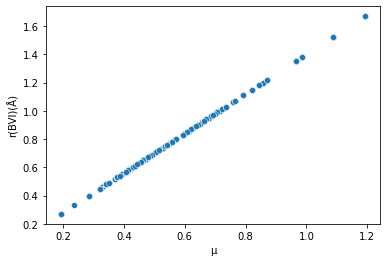

In [22]:
# From your data analysis, create two visuals that demonstrate key findings of interest to a stakeholder. 

sns.scatterplot(data = df, x =df['μ'] ,y= df['r(BVI)(Å)']);

#We see that x is the octahedral factor and y is the ionic radius of the X anion and they are completely postively correlated
#The octahedral factor is a parameter for predicting structure stability. When μ > 0.41, the structure is stable.
#so we see that all radii above 0.6 are most likely to have stable crystal structures.

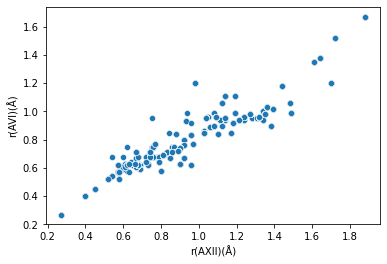

In [23]:
sns.scatterplot(data = df, x =df['r(AXII)(Å)'] ,y= df['r(AVI)(Å)']);    

# We see that x is the ionic radius of A cation and y is the ionic rdaius of the B cation and they are strongly positively correlated.
# From the previous graph we saw that all radii above 0.6 are most likely to have stablely structures.
# Thus we can infer that the cations above 0.6 will also have stable crystal structures. 
# We also see that the closer in size of the radii the more they correlate.

In [43]:
# Loading libraries to complete the appropriate pre-processing steps
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector, make_column_transformer

# Trying multiple models and tuning the hyperparameters of each model to optimize model performance 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTENC #using an oversampling technique to balance the imbalanced data

In [35]:
y= df['Lowest distortion'] 
X = df.drop(columns = 'Lowest distortion')

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42, stratify = y) #added stratify to make my target column balanced

smt = SMOTENC(random_state = 42, categorical_features=[0, 1])
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

In [39]:
ss = StandardScaler()
ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore') #for the elements

cat_sel = make_column_selector(dtype_include = 'object') 
num_sel = make_column_selector(dtype_include = 'number')

cat_tup = (ohe, cat_sel)
num_tup = (ss, num_sel)

prep = make_column_transformer(cat_tup, num_tup)

prep.fit(X_train_sm,y_train_sm)

ColumnTransformer(transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f0fae701bd0>),
                                ('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f0fae701390>)])

In [56]:
knn = KNeighborsClassifier()
knn_pipe = make_pipeline(prep, knn)
kparams = {'kneighborsclassifier__n_neighbors': range(1,6), #first tried 1-51, 5 was best so tried to focus under 5
           'kneighborsclassifier__weights': ["uniform",'distance'],
           'kneighborsclassifier__p': range(1,4)}
knn_grid = GridSearchCV(knn_pipe, kparams) #using grid search to iterate through the parameters
knn_grid.fit(X_train_sm, y_train_sm)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f0fae701bd0>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f0fae701390>)])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
 

In [57]:
knn_grid.best_params_ #5, distance, 1 before smote. after smote 2, uniform, 2

{'kneighborsclassifier__n_neighbors': 2,
 'kneighborsclassifier__p': 2,
 'kneighborsclassifier__weights': 'uniform'}

In [58]:
best_knn = knn_grid.best_estimator_

knn_train_pred= best_knn.predict(X_train)
knn_test_pred= best_knn.predict(X_test)

knn_train_acc = accuracy_score(y_train,knn_train_pred)
knn_test_acc = accuracy_score(y_test,knn_test_pred)

print(knn_train_acc)
print(knn_test_acc)

#this model has high variance because the training performed better than the test

0.9589643380556913
0.7569546120058566


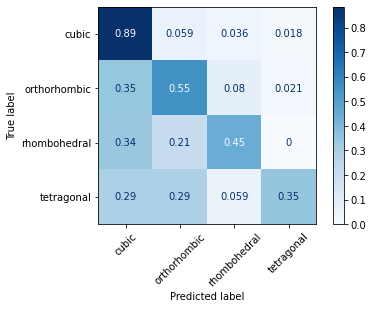

In [48]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test.values, knn_test_pred) #actual target values vs the model's predicted values

cm_df = pd.DataFrame(cm) #changing cm from a numpy array to a data frame so it will be easier to plot

from sklearn.metrics import ConfusionMatrixDisplay, classification_report
ConfusionMatrixDisplay.from_predictions(y_test, knn_test_pred, xticks_rotation=45, cmap='Blues', normalize='true');

In [49]:
rfc = RandomForestClassifier()
rfc_pipe = make_pipeline(prep, rfc)
rfc_params = {'randomforestclassifier__n_estimators': [35, 100, 200]} #tried to 100 first and 35 was the best, now 200 is the best, tried a range of 35 to 201 and 200 is still best.
rfc_grid = GridSearchCV (rfc_pipe, rfc_params)
rfc_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f0fae701bd0>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f0fae701390>)])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]

In [50]:
rfc_grid.best_params_ #200

{'randomforestclassifier__n_estimators': 200}

In [51]:
best_rfc = rfc_grid.best_estimator_

rfc_train_pred= best_rfc.predict(X_train)
rfc_test_pred= best_rfc.predict(X_test)

rfc_train_acc = accuracy_score(y_train,rfc_train_pred)
rfc_test_acc = accuracy_score(y_test,rfc_test_pred)

print(rfc_train_acc)
print(rfc_test_acc)

#this model also has high variance because the training performed better than the test
#however, this model performed better on the test data compared to the other model
#thus, this is my final model.

1.0
0.8169838945827232


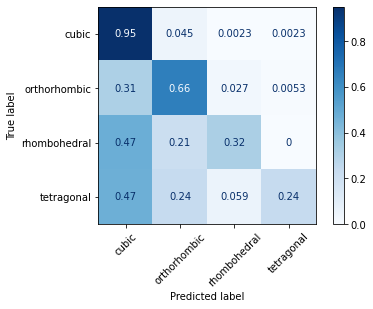

In [59]:
cm2 = confusion_matrix(y_test.values, rfc_test_pred) 

cm2_df = pd.DataFrame(cm2) 

ConfusionMatrixDisplay.from_predictions(y_test, rfc_test_pred, xticks_rotation=45, cmap='Blues', normalize='true'); 

In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import metrics

In [61]:
# Learning history plotting function
def plot_history(history):
  """Takes a keras model learning history and plots each metric"""
  
  metrics = history.history.keys()
  
  for metric in metrics:
      if not 'val' in metric:
        plt.plot(history.history[f'{metric}'], label=f'{metric}')
        if f'val_{metric}' in metrics:
          plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.legend()
        plt.title(f'{metric}')
        plt.show()

In [62]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
# encode labels
encoder = LabelEncoder()
 
encoder.fit(y_train_sm)
y_train_enc = encoder.transform(y_train_sm)
y_test_enc = encoder.transform(y_test)
 
# make a record of the classes, in order of the encoding, in case we want to translate predictions into structure names later.
classes = encoder.classes_
 
# binarize labels
binarizer = LabelBinarizer()
 
binarizer.fit(y_train_enc)
y_train_bin = binarizer.transform(y_train_enc)
y_test_bin = binarizer.transform(y_test_enc)
 
# check results
print('Original Target')
print(y_train.head())
 
print('\nEncoded Target')
print(y_train_enc[:5])
 
print('\nBinarized Target')
print(y_train_bin[:5])

Original Target
2821    orthorhombic
1845    orthorhombic
579            cubic
2408           cubic
3322           cubic
Name: Lowest distortion, dtype: object

Encoded Target
[1 1 0 0 0]

Binarized Target
[[0 1 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]]


In [63]:
X_train_trans = prep.transform(X_train_sm) #did not want to overwrite the xtrain so made a new variable for my neural network
X_test_trans = prep.transform(X_test)

In [64]:
input_num = X_train_trans.shape[1] 
input_num

148

In [133]:
num_classes = len(classes)
 
multi_model = Sequential()
 
#first layer(input layer)
multi_model.add(Dense(148, input_dim=input_num, activation='relu'))
multi_model.add(Dropout(.8))
#second layer (hidden layer)
multi_model.add(Dense(74, activation='relu'))
multi_model.add(Dropout(.8))
#third layer (output layer)
multi_model.add(Dense(num_classes, activation='softmax'))

multi_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', metrics.Precision(), metrics.Recall()])

early_stopping = EarlyStopping(patience = 5) #stops my epochs if the loss starts to increase

hs = multi_model.fit(X_train_trans, y_train_bin, validation_data=(X_test_trans, y_test_bin), epochs=100, verbose=0, callbacks=[early_stopping])

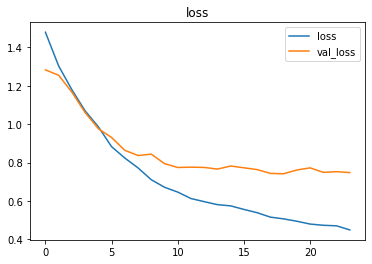

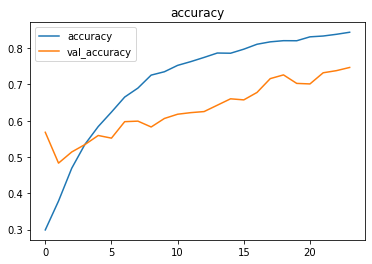

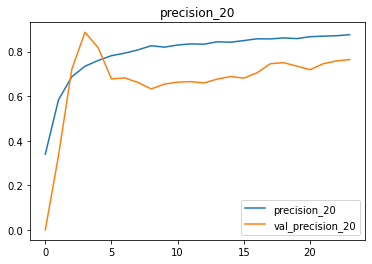

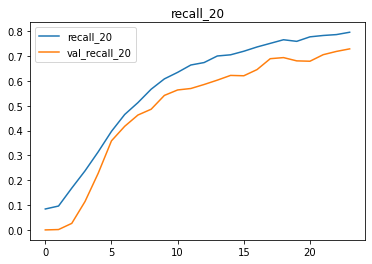

In [134]:
plot_history(hs)

In [97]:
# after several tuning efforts, I found that the less overfit/underfit the neural network is the lower the accuracy gets
# the closer the neural network test and train loss reaches 0 the worse the accuracy.
# I am unsure how to fix it, Ive tried several ways to make to model less complex

              precision    recall  f1-score   support

           0       0.86      0.82      0.84       441
           1       0.63      0.68      0.65       187
           2       0.31      0.32      0.31        38
           3       0.35      0.47      0.40        17

    accuracy                           0.75       683
   macro avg       0.54      0.57      0.55       683
weighted avg       0.76      0.75      0.75       683



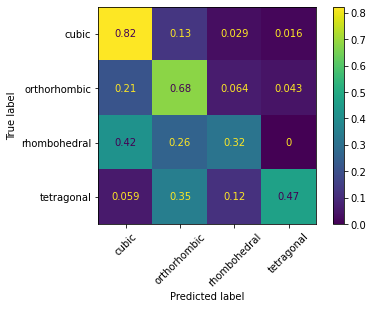

In [135]:
raw_pred = multi_model.predict(X_test_trans)

y_pred = np.argmax(raw_pred, axis=1) # convert predictions and labels into integers representing each structure
y_true = np.argmax(y_test_bin, axis=1)

print(classification_report(y_true, y_pred))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=classes, xticks_rotation=45, normalize= 'true');